In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
!pip install keras_efficientnets

In [3]:
# To have reproducible results and compare them
import json
import math
import os

import scipy as sp
from functools import partial
from collections import Counter
import json

import cv2
from PIL import Image
import numpy as np
from keras import backend as K
from keras import layers
from keras_efficientnets import *
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
from tqdm import tqdm, tqdm_notebook
import gc
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

nr_seed = 2019
import numpy as np 
np.random.seed(nr_seed)
import tensorflow as tf
tf.set_random_seed(nr_seed)

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [4]:
# Image size
im_size = 256
# Batch size
BATCH_SIZE = 32

In [5]:
new_train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
# old_train = pd.read_csv('../input/diabetic-retinopathy-resized/trainLabels.csv')
print(new_train.shape)
# print(old_train.shape)

(3662, 2)


In [6]:
# old_train = old_train[['image','level']]
# old_train.columns = new_train.columns
# old_train.diagnosis.value_counts()

new_train['id_code'] = '../input/aptos2019-blindness-detection/train_images/' + new_train['id_code'].astype(str) + '.png'
# old_train['id_code'] = '../input/diabetic-retinopathy-resized/resized_train/resized_train/' + old_train['id_code'].astype(str) + '.jpeg'

# train_df = old_train.copy()
train_df = new_train.copy()

In [7]:
# Let's shuffle the datasets
train_df = train_df.sample(frac=1).reset_index(drop=True)
# val_df = val_df.sample(frac=1).reset_index(drop=True)
print(train_df.shape)
# print(val_df.shape)

(3662, 2)


In [8]:
def crop_image_from_gray(img, tol=7):
    """
    Applies masks to the orignal image and 
    returns the a preprocessed image with 
    3 channels
    """
    # If for some reason we only have two channels
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    # If we have a normal RGB images
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

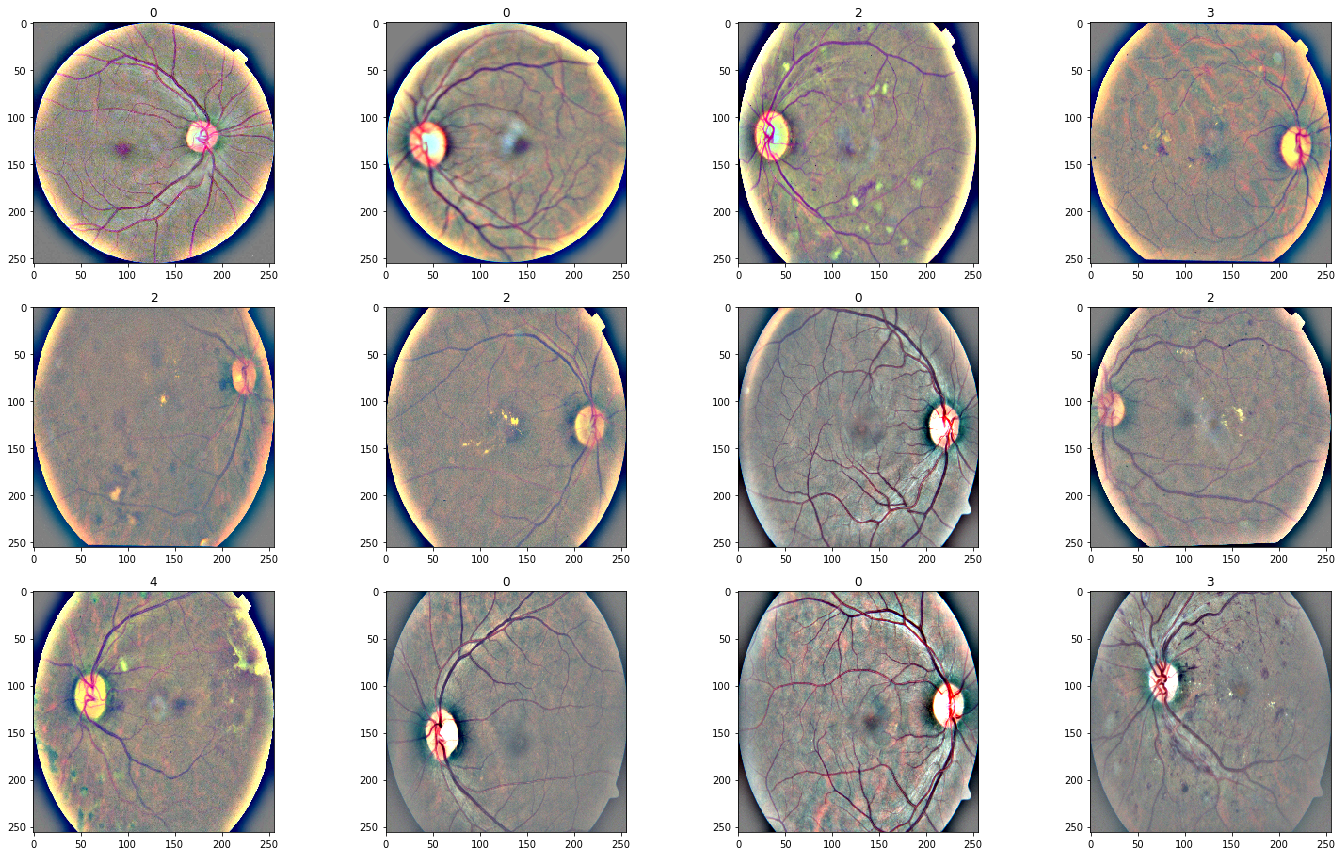

In [9]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread(f'{image_path}')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = crop_image_from_gray(img)
        img = cv2.resize(img, (im_size,im_size))
        img = cv2.addWeighted(img,4,cv2.GaussianBlur(img, (0,0), 10) ,-4 ,128)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

# display train images
display_samples(train_df)

In [10]:
from keras.utils import to_categorical
y_train = train_df['diagnosis'].values
# y_val = val_df['diagnosis'].values
    
x_train = train_df['id_code']
# x_val = val_df['id_code']

# y_train = to_categorical(y_train)
# y_val = to_categorical(y_val)

In [11]:
from albumentations import *
import matplotlib.pyplot as plt

allaug = Compose([
            Rotate(p=0.7, limit=(0,360), border_mode=0,value=0), # value=black
            VerticalFlip(p=0.3),
            HorizontalFlip(p=0.3),
            RandomBrightnessContrast(brightness_limit=0.45, contrast_limit=0.45,p=0.8),
            ShiftScaleRotate(shift_limit=0, rotate_limit=0, scale_limit=(0.24, 0.24), border_mode=0, p=1)
        ], p=0.9)

def albaugment(img, aug0=allaug):
    return aug0(image=img)['image']

In [12]:
# # '../input/aptos2019-blindness-detection/train_images/96ea316ed0ab.png'
# pt = '../input/aptos2019-blindness-detection/train_images/1d3e9b939732.png'
# img = cv2.imread(pt)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = crop_image_from_gray(img)
# img = cv2.resize(img, (im_size,im_size))
# img = cv2.addWeighted(img,4,cv2.GaussianBlur(img, (0,0), 10) ,-4 ,128)
# a = albaugment(img)
# plt.imshow(a)

In [13]:
IMG_SIZE = 256

from keras.utils import Sequence

class MyGenerator(Sequence):

    def __init__(self, image_filenames, labels,
                 batch_size, is_train=False,
                 mix=False, augment=False):
        self.image_filenames, self.labels = image_filenames, labels
        self.batch_size = batch_size
        self.is_train = is_train
        self.is_augment = augment
        if(self.is_train):
            self.on_epoch_end()
        self.is_mix = mix

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        if(self.is_train):
            return self.train_generate(batch_x, batch_y)
        return self.valid_generate(batch_x, batch_y)

    def on_epoch_end(self):
        if(self.is_train):
            self.image_filenames, self.labels = shuffle(self.image_filenames, self.labels)
    
    def mix_up(self, x, y):
        lam = np.random.beta(0.2, 0.4)
        ori_index = np.arange(int(len(x)))
        index_array = np.arange(int(len(x)))
        np.random.shuffle(index_array)        
        
        mixed_x = lam * x[ori_index] + (1 - lam) * x[index_array]
        mixed_y = lam * y[ori_index] + (1 - lam) * y[index_array]
        
        return mixed_x, mixed_y

    def train_generate(self, batch_x, batch_y):
        batch_images = []
        for (sample, label) in zip(batch_x, batch_y):
#             img = cv2.imread('../input/aptos2019-blindness-detection/train_images/'+sample+'.png')
#             path = '../input/diabetic-retinopathy-resized/resized_train/resized_train'+sample+'.png'
            img = self.load_ben_color(sample,sigmaX=10)
#             img = cv2.resize(img, (SIZE, SIZE))
            if(self.is_augment):
                img = albaugment(img)
            batch_images.append(img)
        batch_images = np.array(batch_images, np.float32) / 255
        batch_y = np.array(batch_y, np.float32)
        if(self.is_mix):
            batch_images, batch_y = self.mix_up(batch_images, batch_y)
        return batch_images, batch_y

    def valid_generate(self, batch_x, batch_y):
        batch_images = []
        for (sample, label) in zip(batch_x, batch_y):
#             path = '../input/aptos2019-blindness-detection/train_images/'+sample+'.png'
            img = self.load_ben_color(sample,sigmaX=10)
#             img = cv2.resize(img, (SIZE, SIZE))
            batch_images.append(img)
        batch_images = np.array(batch_images, np.float32) / 255
        batch_y = np.array(batch_y, np.float32)
        return batch_images, batch_y
    
    def load_ben_color(self, path, sigmaX=10):
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.crop_image_from_gray(image)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image = cv2.addWeighted (image, 4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)        
        return image

#     def crop_image1(self, img,tol=7):
#         # img is image data
#         # tol  is tolerance    
#         mask = img>tol
#         return img[np.ix_(mask.any(1),mask.any(0))]

    def crop_image_from_gray(self, img,tol=7):
        if img.ndim ==2:
            mask = img>tol
            return img[np.ix_(mask.any(1),mask.any(0))]
        elif img.ndim==3:
            gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            mask = gray_img>tol

            check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
            if (check_shape == 0): # image is too dark so that we crop out everything,
                return img # return original image
            else:
                img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
                img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
                img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
        #         print(img1.shape,img2.shape,img3.shape)
                img = np.stack([img1,img2,img3],axis=-1)
        #         print(img.shape)
            return img 

In [14]:
effnet = EfficientNetB3(input_shape=(IMG_SIZE,IMG_SIZE, 3), weights=None, include_top=False)

In [15]:
def build_model():
    model = Sequential()
    model.add(effnet)
    model.add(layers.GlobalAveragePooling2D())
#     model.add(layers.Dropout(0.5))
#     model.add(layers.Dense(2056))
#     model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))
    model.add(layers.Dense(1, activation='linear'))
    return model

model = build_model()

for layer in model.layers:
    layer.trainable = True

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 8, 8, 1536)        10783528  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 7685      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 10,791,219
Trainable params: 10,703,923
Non-trainable params: 87,296
_________________________________________________________________


In [16]:
class Metrics(Callback):
    """
    A custom Keras callback for saving the best model
    according to the Quadratic Weighted Kappa (QWK) metric
    """
    def on_train_begin(self, logs={}):
        """
        Initialize list of QWK scores on validation data
        """
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        """
        Gets QWK score on the validation data
        """
        # Get predictions and convert to integers
#         y_pred, labels = get_preds_and_labels(model, valid_generator)
        y_pred = model.predict_generator(generator=valid_generator,
                                      steps=np.ceil(float(len(yvalid_reg)) / float(batch_size)),
                                      workers=1, use_multiprocessing=True,
                                      verbose=1)
#         y_pred = y_pred.reshape((64,))
        y_pred = np.rint(y_pred).astype(np.uint8).clip(0, 4)
        # We can use sklearns implementation of QWK straight out of the box
        # as long as we specify weights as 'quadratic'
        _val_kappa = cohen_kappa_score(yvalid_reg, y_pred, weights='quadratic')
        self.val_kappas.append(_val_kappa)
        print(f"val_kappa: {round(_val_kappa, 4)}")
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save_weights('../working/QWK_metric_save.h5')
        return
qwk = Metrics()

In [17]:
def get_preds_and_labels(model, xval, yval):
    """
    Get predictions and labels from the generator
    """
    preds = []
    labels = []
    for path in xval:
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = crop_image_from_gray(img)
        img = cv2.resize(img, (im_size,im_size))
        img = cv2.addWeighted(img,4,cv2.GaussianBlur(img, (0,0), 10) ,-4 ,128)
        preds.append(model.predict(img[np.newaxis])[0])
        labels = list(yval)
    # Flatten list of numpy arrays
    return preds,labels

In [18]:
class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa score
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        """
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        """
        Optimize rounding thresholds
        """
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        """
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [19]:
from keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint, CSVLogger
from sklearn.utils import class_weight, shuffle
from sklearn.model_selection import StratifiedKFold

Skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
batch_size = 32
i = 1
n_fold = 5

model.load_weights('../input/changed-labels-warmup-1op-regressiondrhb-old/QWK_metric_save.h5')
model.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics = ['mse', 'acc'])  

lis_coeff = []
new_scores = []

for train_index, test_index in Skf.split(x_train, y_train):    
    xtrain_reg = x_train.iloc[train_index]; xvalid_reg = x_train.iloc[test_index]
    ytrain_reg = y_train[train_index]; yvalid_reg = y_train[test_index]
    
#     ytrain_skf = to_categorical(ytrain_skf)
#     y_train_multi = np.empty(ytrain_skf.shape, dtype=ytrain_skf.dtype)
#     y_train_multi[:, 4] = ytrain_skf[:, 4]
#     for i in range(3, -1, -1):
#         y_train_multi[:, i] = np.logical_or(ytrain_skf[:, i], y_train_multi[:, i+1])
        
        
#     yvalid_skf = to_categorical(yvalid_skf)
#     y_val_multi = np.empty(yvalid_skf.shape, dtype=yvalid_skf.dtype)
#     y_val_multi[:, 4] = yvalid_skf[:, 4]
#     for i in range(3, -1, -1):
#         y_val_multi[:, i] = np.logical_or(yvalid_skf[:, i], y_val_multi[:, i+1])
    
    
    train_generator = MyGenerator(xtrain_reg, ytrain_reg, 128, is_train=True)
    train_mixup = MyGenerator(xtrain_reg, ytrain_reg, batch_size, is_train=True, mix=False, augment=True)
    valid_generator = MyGenerator(xvalid_reg, yvalid_reg, batch_size, is_train=False)
    
    checkpoint = ModelCheckpoint('../working/model_checkpoint.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=True)
    reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, mode='auto', patience=3, verbose=1)
#     lrschedule = LearningRateScheduler(schedule=, verbose=1)
#     earlystop = EarlyStopping(monitor='val_loss', mode='min', patience=10)
    csvlog = CSVLogger('../working/model_logs.csv', separator=',', append=True)
    
    qwk = Metrics()
    
    callbacks_list = [checkpoint, csvlog, reducelr, qwk]
    
    history = model.fit_generator(
        train_mixup,
        steps_per_epoch=np.ceil(float(len(xtrain_reg)) / float(batch_size)),
        validation_data=valid_generator,
        validation_steps=np.ceil(float(len(xvalid_reg)) / float(batch_size)),
        epochs=5,
        verbose=1,
        workers=1, use_multiprocessing=False,
        callbacks=callbacks_list)
    
    # Optimize on validation data and evaluate again
    y_val_preds, val_labels = get_preds_and_labels(model, xvalid_reg, yvalid_reg)
    optR = OptimizedRounder()
    optR.fit(y_val_preds, val_labels)
    coefficients = optR.coefficients()
    opt_val_predictions = optR.predict(y_val_preds, coefficients)
    new_val_score = cohen_kappa_score(val_labels, opt_val_predictions, weights="quadratic")
    
    lis_coeff.append(coefficients)
    new_scores.append(new_val_score)
    
    i = i + 1
    if i <= n_fold:
        print(f'\n\n\nNow beginning training for fold {i}\n\n')
    else:
        print('Finished training!')
    
    model.save_weights(f'../working/skfoldval_{i}.h5')
    

mylogs = pd.DataFrame({'coefficients':lis_coeff,
                       'new-scores':new_scores})
mylogs.to_csv('../working/my_logs.csv', index=True)
    

Epoch 1/5
92/92 [==============================] - 619s 7s/step - loss: 0.5945 - mean_squared_error: 0.5945 - acc: 0.7444 - val_loss: 0.5076 - val_mean_squared_error: 0.5076 - val_acc: 0.7776

Epoch 00001: val_loss improved from inf to 0.50756, saving model to ../working/model_checkpoint.h5
23/23 [==============================] - 147s 6s/step
val_kappa: 0.8176
Validation Kappa has improved. Saving model.
Epoch 2/5
92/92 [==============================] - 507s 6s/step - loss: 0.5077 - mean_squared_error: 0.5077 - acc: 0.7664 - val_loss: 0.4808 - val_mean_squared_error: 0.4808 - val_acc: 0.7858

Epoch 00002: val_loss improved from 0.50756 to 0.48084, saving model to ../working/model_checkpoint.h5
23/23 [==============================] - 140s 6s/step
val_kappa: 0.8205
Validation Kappa has improved. Saving model.
Epoch 3/5
92/92 [==============================] - 509s 6s/step - loss: 0.4905 - mean_squared_error: 0.4905 - acc: 0.7631 - val_loss: 0.4716 - val_mean_squared_error: 0.4716 - va

In [20]:
# from keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint, CSVLogger
# from sklearn.utils import class_weight, shuffle

# epochs = 30
# batch_size = 32

# checkpoint = ModelCheckpoint('../working/checkpoints', monitor='val_loss', save_best_only=True, mode='min', save_weights_only=True)
# reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, mode='auto', patience=3, verbose=1)
# # lrschedule = LearningRateScheduler(schedule=, verbose=1)
# earlystop = EarlyStopping(monitor='val_acc', mode='max', patience=10)
# csvlog = CSVLogger('../working/model_logs.csv', separator=',', append=True)

# train_generator = MyGenerator(x_train, y_train, 128, is_train=True)
# train_mixup = MyGenerator(x_train, y_train, batch_size, is_train=True, mix=False, augment=True)
# valid_generator = MyGenerator(x_val, y_val, batch_size, is_train=False)

# model = create_model((IMG_SIZE,IMG_SIZE,3), 5)

In [21]:
# WORKERS = 2
# from keras.optimizers import Adam

# for layer in model.layers:
#     layer.trainable = False

# for i in range(-5,0):
#     model.layers[i].trainable=True

# model.compile(loss='categorical_crossentropy', optimizer=Adam(1e-3))

# model.fit_generator(train_generator, steps_per_epoch=np.ceil(float(len(y_train))/float(128)), epochs=2, workers=WORKERS, use_multiprocessing=True, verbose=1,
#                   callbacks=[qwk])

In [22]:
# for layer in model.layers:
#     layer.trainable = True
    
# callbacks_list = [checkpoint, csvlog, earlystop, reducelr, qwk]

# model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-6/2), metrics=['acc'])

# history = model.fit_generator(
#     train_mixup,
#     steps_per_epoch=np.ceil(float(len(x_train)) / float(batch_size)),
#     validation_data=valid_generator,
#     validation_steps=np.ceil(float(len(x_val)) / float(batch_size)),
#     epochs=epochs,
#     verbose=1,
#     workers=1, use_multiprocessing=False,
#     callbacks=callbacks_list)

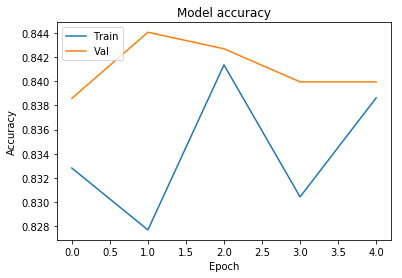

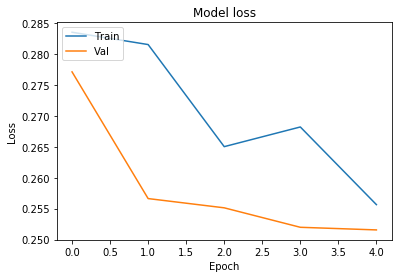

In [23]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()